# Subject4: Latency and capacity estimation for a network connection from asymmetric measurements

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
from os import path
import urllib.request as request
import gzip as gz
import shutil
import re
from collections import OrderedDict
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

## Data

In [2]:
def download_file(url, filename) :
    if not path.exists(filename) :
        print("No local data copy available for " + filename + ", creating new version")
        request.urlretrieve(url, filename)
    else :
        print("Using local version of " + filename)

First data to examine, ping traces from on-campus connection.
We first check if a local copy of the data exists. If no copy is available, a new archive is downloaded.

In [3]:
liglab2_url = "http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz"
liglab2_file = "liglab2.log.gz"

download_file(liglab2_url, liglab2_file)

Using local version of liglab2.log.gz


Second data to examine, ping traces from stackoverflow. As before, we download the file if a local copy doesn't already exist.

In [4]:
stackoverflow_url = "http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz"
stackoverflow_file = "stackoverflow.log.gz"

download_file(stackoverflow_url, stackoverflow_file)

Using local version of stackoverflow.log.gz


The files are log files with the following syntaxe:

_[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms_

which can be described as the following

_[`timestamp`] `size` bytes from `url` (`ip`): icmp_seq=`icmp_seq` ttl=`ttl` time=`time` ms_

| Variable name  | Description                                                               |
|----------------|---------------------------------------------------------------------------|
| `timestamp`    | Epoch time in seconds as from the 1st January  1970                       |
| `size`         | Size of packet transmitted in bytes                                       |
| `url`          | DNS resolution of server with which packets are being exchanged           |
| `ip`           | IPv4 addresse of server with which packets are being exchanged            |
| `icmp_seq`     | The sequence number of the ICMP packet (**not used in this analysis**)      |
| `ttl`          | The time-to-live of the ICMP packet (**not used in this analysis**)         |
| `time`         | The round trip duration with the server in miliseconds                    |

Both `icmp_seq` and `ttl` are not used in this analysis, but they will be extracted from the files to retain file integrety.

## 1st analysis: Liglab2

### Prepare the data

We will start our analysis with the first datafile, from Liglab2. Because many of the operations will be the same for the other analysis, we will create functions to accomplish the tasks.

The first operation is to decompress te archive and load the file into an array in memory. We will print the contents to check the operation.

In [5]:
def decompress_archive (archive):
    with gz.open(archive, 'rt') as f_in:
        content = f_in.read().split("\n")
    return content

liglab2_decompressed = decompress_archive(liglab2_file)
liglab2_decompressed

['[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms',
 '[1421761682.277315] 1373 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=21.2 ms',
 '[1421761682.502054] 262 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=21.2 ms',
 '[1421761682.729257] 1107 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=23.3 ms',
 '[1421761682.934648] 1128 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=1.41 ms',
 '[1421761683.160397] 489 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=21.9 ms',
 '[1421761683.443055] 1759 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=78.7 ms',
 '[1421761683.672157] 1146 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=25.1 ms',
 '[1421761683.899933] 884 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=24.0 ms',
 '[1421761684.122687] 1422 bytes from lig-publig.imag.fr (1

Next, to analyse the data we must parse its textual form and extract all the variables. To do so we use multiple regex expressions to recover the different variables. If no variable is found, then it is set to `None`. Once again we print the contents to check if all went correctly.

In [6]:
reg = [('timestamp',r'\[([0-9]+\.[0-9]+)\]', float),
        ('size', r'([1-9][0-9]*) bytes', int),
        ('url', r'from ([-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/=]*)?)', str),
        ('ip', r'\(\b((25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9]))\b\)', str),
        ('icmp_seq', r'icmp_seq=([1-9][0-9]*)', int),
        ('ttl', r'ttl=([0-9]|[1-9][0-9]*)', int),
        ('time', r'time=([0-9]|[1-9][0-9]*(\.[0-9]+)?) ms', float)]

def extract_data (content, reg):
    list = []
    for line in content:
        values = OrderedDict()
        if line:
            for (name, regex, func) in reg:
                obj = re.findall(regex, line)
                val = None
                if len(obj) :
                    val = obj[0]
                    if isinstance(val, tuple) and len(val) :
                        val = val[0]
                    val = func(val)
                values[name] = val
            list.append(values)
    return list

liglab2_contents = extract_data(liglab2_decompressed, reg)
liglab2_contents

[OrderedDict([('timestamp', 1421761682.052172),
              ('size', 665),
              ('url', 'lig-publig.imag.fr'),
              ('ip', '129.88.11.7'),
              ('icmp_seq', 1),
              ('ttl', 6),
              ('time', 22.5)]),
 OrderedDict([('timestamp', 1421761682.277315),
              ('size', 1373),
              ('url', 'lig-publig.imag.fr'),
              ('ip', '129.88.11.7'),
              ('icmp_seq', 1),
              ('ttl', 6),
              ('time', 21.2)]),
 OrderedDict([('timestamp', 1421761682.502054),
              ('size', 262),
              ('url', 'lig-publig.imag.fr'),
              ('ip', '129.88.11.7'),
              ('icmp_seq', 1),
              ('ttl', 6),
              ('time', 21.2)]),
 OrderedDict([('timestamp', 1421761682.729257),
              ('size', 1107),
              ('url', 'lig-publig.imag.fr'),
              ('ip', '129.88.11.7'),
              ('icmp_seq', 1),
              ('ttl', 6),
              ('time', 23.3)]),
 Order

now that we have extracted the data and converted it into string and numerical values, we can create a pandas dataframe to be able to do our analysis.

In [7]:
liglab2_raw_data = pd.DataFrame(liglab2_contents)
liglab2_raw_data

timestamp  size                 url           ip  icmp_seq  ttl  \
0      1.421762e+09   665  lig-publig.imag.fr  129.88.11.7         1    6   
1      1.421762e+09  1373  lig-publig.imag.fr  129.88.11.7         1    6   
2      1.421762e+09   262  lig-publig.imag.fr  129.88.11.7         1    6   
3      1.421762e+09  1107  lig-publig.imag.fr  129.88.11.7         1    6   
4      1.421762e+09  1128  lig-publig.imag.fr  129.88.11.7         1    6   
5      1.421762e+09   489  lig-publig.imag.fr  129.88.11.7         1    6   
6      1.421762e+09  1759  lig-publig.imag.fr  129.88.11.7         1    6   
7      1.421762e+09  1146  lig-publig.imag.fr  129.88.11.7         1    6   
8      1.421762e+09   884  lig-publig.imag.fr  129.88.11.7         1    6   
9      1.421762e+09  1422  lig-publig.imag.fr  129.88.11.7         1    6   
10     1.421762e+09  1180  lig-publig.imag.fr  129.88.11.7         1    6   
11     1.421762e+09   999  lig-publig.imag.fr  129.88.11.7         1    6   
12     1.421762e+09    21  lig-publig.imag.fr  129.88.11.7         1    6   
13     1.421762e+09  1020  lig-publig.imag.fr  129.88.11.7         1    6   
14     1.421762e+09    71  lig-publig.imag.fr  129.88.11.7         1    6   
15     1.421762e+09    34  lig-publig.imag.fr  129.88.11.7         1    6   
16     1.421762e+09  1843  lig-publig.imag.fr  129.88.11.7         1    6   
17     1.421762e+09   407  lig-publig.imag.fr  129.88.11.7         1    6   
18     1.421762e+09   356  lig-publig.imag.fr  129.88.11.7         1    6   
19     1.421762e+09  1511  lig-publig.imag.fr  129.88.11.7         1    6   
20     1.421762e+09   587  lig-publig.imag.fr  129.88.11.7         1    6   
21     1.421762e+09   809  lig-publig.imag.fr  129.88.11.7         1    6   
22     1.421762e+09  1364  lig-publig.imag.fr  129.88.11.7         1    6   
23     1.421762e+09  1153  lig-publig.imag.fr  129.88.11.7         1    6   
24     1.421762e+09   853  lig-publig.imag.fr  129.88.11.7         1    6   
25     1.421762e+09  1510  lig-publig.imag.fr  129.88.11.7         1    6   
26     1.421762e+09   123  lig-publig.imag.fr  129.88.11.7         1    6   
27     1.421762e+09  1966  lig-publig.imag.fr  129.88.11.7         1    6   
28     1.421762e+09   933  lig-publig.imag.fr  129.88.11.7         1    6   
29     1.421762e+09   922  lig-publig.imag.fr  129.88.11.7         1    6   
...             ...   ...                 ...          ...       ...  ...   
44383  1.421771e+09  1772  lig-publig.imag.fr  129.88.11.7         1    6   
44384  1.421771e+09    41  lig-publig.imag.fr  129.88.11.7         1    6   
44385  1.421771e+09  1944  lig-publig.imag.fr  129.88.11.7         1    6   
44386  1.421771e+09   400  lig-publig.imag.fr  129.88.11.7         1    6   
44387  1.421771e+09   226  lig-publig.imag.fr  129.88.11.7         1    6   
44388  1.421771e+09   466  lig-publig.imag.fr  129.88.11.7         1    6   
44389  1.421771e+09   350  lig-publig.imag.fr  129.88.11.7         1    6   
44390  1.421771e+09  1829  lig-publig.imag.fr  129.88.11.7         1    6   
44391  1.421771e+09  1954  lig-publig.imag.fr  129.88.11.7         1    6   
44392  1.421771e+09  1074  lig-publig.imag.fr  129.88.11.7         1    6   
44393  1.421771e+09    46  lig-publig.imag.fr  129.88.11.7         1    6   
44394  1.421771e+09  1844  lig-publig.imag.fr  129.88.11.7         1    6   
44395  1.421771e+09   645  lig-publig.imag.fr  129.88.11.7         1    6   
44396  1.421771e+09   444  lig-publig.imag.fr  129.88.11.7         1    6   
44397  1.421771e+09  1940  lig-publig.imag.fr  129.88.11.7         1    6   
44398  1.421771e+09  1411  lig-publig.imag.fr  129.88.11.7         1    6   
44399  1.421771e+09    49  lig-publig.imag.fr  129.88.11.7         1    6   
44400  1.421771e+09   420  lig-publig.imag.fr  129.88.11.7         1    6   
44401  1.421771e+09   227  lig-publig.imag.fr  129.88.11.7         1    6   
44402  1.421771e+09   947  lig-publig.imag.fr  129.88.11.7         1    6   
44403 

Before continuing, we must verify if any invalid entries have been extracted from the data file.

In [8]:
liglab2_raw_data[liglab2_raw_data.isnull().any(axis=1)]

timestamp  size                 url           ip  icmp_seq  ttl  \
12     1.421762e+09    21  lig-publig.imag.fr  129.88.11.7         1    6   
116    1.421762e+09     9  lig-publig.imag.fr  129.88.11.7         1    6   
314    1.421762e+09     9  lig-publig.imag.fr  129.88.11.7         1    6   
508    1.421762e+09     9  lig-publig.imag.fr  129.88.11.7         1    6   
590    1.421762e+09    18  lig-publig.imag.fr  129.88.11.7         1    6   
647    1.421762e+09    18  lig-publig.imag.fr  129.88.11.7         1    6   
1087   1.421762e+09    18  lig-publig.imag.fr  129.88.11.7         1    6   
1091   1.421762e+09    13  lig-publig.imag.fr  129.88.11.7         1    6   
1131   1.421762e+09    20  lig-publig.imag.fr  129.88.11.7         1    6   
1153   1.421762e+09    21  lig-publig.imag.fr  129.88.11.7         1    6   
1350   1.421762e+09    15  lig-publig.imag.fr  129.88.11.7         1    6   
1542   1.421762e+09    17  lig-publig.imag.fr  129.88.11.7         1    6   
1691   1.421762e+09    19  lig-publig.imag.fr  129.88.11.7         1    6   
1765   1.421762e+09     9  lig-publig.imag.fr  129.88.11.7         1    6   
1957   1.421762e+09    21  lig-publig.imag.fr  129.88.11.7         1    6   
2099   1.421762e+09     8  lig-publig.imag.fr  129.88.11.7         1    6   
2182   1.421762e+09    23  lig-publig.imag.fr  129.88.11.7         1    6   
2209   1.421762e+09    10  lig-publig.imag.fr  129.88.11.7         1    6   
2455   1.421762e+09    21  lig-publig.imag.fr  129.88.11.7         1    6   
2478   1.421762e+09    16  lig-publig.imag.fr  129.88.11.7         1    6   
2722   1.421762e+09    19  lig-publig.imag.fr  129.88.11.7         1    6   
2734   1.421762e+09    21  lig-publig.imag.fr  129.88.11.7         1    6   
3042   1.421762e+09    10  lig-publig.imag.fr  129.88.11.7         1    6   
3064   1.421762e+09     9  lig-publig.imag.fr  129.88.11.7         1    6   
3185   1.421762e+09    22  lig-publig.imag.fr  129.88.11.7         1    6   
3222   1.421762e+09    10  lig-publig.imag.fr  129.88.11.7         1    6   
3318   1.421762e+09    10  lig-publig.imag.fr  129.88.11.7         1    6   
3333   1.421762e+09    10  lig-publig.imag.fr  129.88.11.7         1    6   
3494   1.421762e+09     8  lig-publig.imag.fr  129.88.11.7         1    6   
3689   1.421762e+09     9  lig-publig.imag.fr  129.88.11.7         1    6   
...             ...   ...                 ...          ...       ...  ...   
39760  1.421770e+09    14  lig-publig.imag.fr  129.88.11.7         1    6   
39929  1.421770e+09    22  lig-publig.imag.fr  129.88.11.7         1    6   
40039  1.421770e+09    22  lig-publig.imag.fr  129.88.11.7         1    6   
40398  1.421770e+09    12  lig-publig.imag.fr  129.88.11.7         1    6   
40659  1.421770e+09     8  lig-publig.imag.fr  129.88.11.7         1    6   
40704  1.421770e+09    20  lig-publig.imag.fr  129.88.11.7         1    6   
40882  1.421770e+09    15  lig-publig.imag.fr  129.88.11.7         1    6   
41276  1.421771e+09    12  lig-publig.imag.fr  129.88.11.7         1    6   
41421  1.421771e+09    16  lig-publig.imag.fr  129.88.11.7         1    6   
41494  1.421771e+09    22  lig-publig.imag.fr  129.88.11.7         1    6   
41689  1.421771e+09    15  lig-publig.imag.fr  129.88.11.7         1    6   
41833  1.421771e+09    17  lig-publig.imag.fr  129.88.11.7         1    6   
42094  1.421771e+09    10  lig-publig.imag.fr  129.88.11.7         1    6   
42119  1.421771e+09    21  lig-publig.imag.fr  129.88.11.7         1    6   
42165  1.421771e+09    18  lig-publig.imag.fr  129.88.11.7         1    6   
42171  1.421771e+09     9  lig-publig.imag.fr  129.88.11.7         1    6   
42216  1.421771e+09    17  lig-publig.imag.fr  129.88.11.7         1    6   
42290  1.421771e+09    17  lig-publig.imag.fr  129.88.11.7         1    6   
42391  1.421771e+09    17  lig-publig.imag.fr  129.88.11.7         1    6   
42440  1.421771e+09    14  lig-publig.imag.fr  129.88.11.7         1    6   
42648 

Here we notive that there are multiple invalid values, where the `time` variable is empty. Since this value is important for the analysis, we cannot use this data entry. We can therefore extract the erroneous lines as they will have little impact on the overall analysis.

In [9]:
liglab2_data = liglab2_raw_data.dropna().copy()
liglab2_data

timestamp  size                 url           ip  icmp_seq  ttl  \
0      1.421762e+09   665  lig-publig.imag.fr  129.88.11.7         1    6   
1      1.421762e+09  1373  lig-publig.imag.fr  129.88.11.7         1    6   
2      1.421762e+09   262  lig-publig.imag.fr  129.88.11.7         1    6   
3      1.421762e+09  1107  lig-publig.imag.fr  129.88.11.7         1    6   
4      1.421762e+09  1128  lig-publig.imag.fr  129.88.11.7         1    6   
5      1.421762e+09   489  lig-publig.imag.fr  129.88.11.7         1    6   
6      1.421762e+09  1759  lig-publig.imag.fr  129.88.11.7         1    6   
7      1.421762e+09  1146  lig-publig.imag.fr  129.88.11.7         1    6   
8      1.421762e+09   884  lig-publig.imag.fr  129.88.11.7         1    6   
9      1.421762e+09  1422  lig-publig.imag.fr  129.88.11.7         1    6   
10     1.421762e+09  1180  lig-publig.imag.fr  129.88.11.7         1    6   
11     1.421762e+09   999  lig-publig.imag.fr  129.88.11.7         1    6   
13     1.421762e+09  1020  lig-publig.imag.fr  129.88.11.7         1    6   
14     1.421762e+09    71  lig-publig.imag.fr  129.88.11.7         1    6   
15     1.421762e+09    34  lig-publig.imag.fr  129.88.11.7         1    6   
16     1.421762e+09  1843  lig-publig.imag.fr  129.88.11.7         1    6   
17     1.421762e+09   407  lig-publig.imag.fr  129.88.11.7         1    6   
18     1.421762e+09   356  lig-publig.imag.fr  129.88.11.7         1    6   
19     1.421762e+09  1511  lig-publig.imag.fr  129.88.11.7         1    6   
20     1.421762e+09   587  lig-publig.imag.fr  129.88.11.7         1    6   
21     1.421762e+09   809  lig-publig.imag.fr  129.88.11.7         1    6   
22     1.421762e+09  1364  lig-publig.imag.fr  129.88.11.7         1    6   
23     1.421762e+09  1153  lig-publig.imag.fr  129.88.11.7         1    6   
24     1.421762e+09   853  lig-publig.imag.fr  129.88.11.7         1    6   
25     1.421762e+09  1510  lig-publig.imag.fr  129.88.11.7         1    6   
26     1.421762e+09   123  lig-publig.imag.fr  129.88.11.7         1    6   
27     1.421762e+09  1966  lig-publig.imag.fr  129.88.11.7         1    6   
28     1.421762e+09   933  lig-publig.imag.fr  129.88.11.7         1    6   
29     1.421762e+09   922  lig-publig.imag.fr  129.88.11.7         1    6   
30     1.421762e+09    24  lig-publig.imag.fr  129.88.11.7         1    6   
...             ...   ...                 ...          ...       ...  ...   
44383  1.421771e+09  1772  lig-publig.imag.fr  129.88.11.7         1    6   
44384  1.421771e+09    41  lig-publig.imag.fr  129.88.11.7         1    6   
44385  1.421771e+09  1944  lig-publig.imag.fr  129.88.11.7         1    6   
44386  1.421771e+09   400  lig-publig.imag.fr  129.88.11.7         1    6   
44387  1.421771e+09   226  lig-publig.imag.fr  129.88.11.7         1    6   
44388  1.421771e+09   466  lig-publig.imag.fr  129.88.11.7         1    6   
44389  1.421771e+09   350  lig-publig.imag.fr  129.88.11.7         1    6   
44390  1.421771e+09  1829  lig-publig.imag.fr  129.88.11.7         1    6   
44391  1.421771e+09  1954  lig-publig.imag.fr  129.88.11.7         1    6   
44392  1.421771e+09  1074  lig-publig.imag.fr  129.88.11.7         1    6   
44393  1.421771e+09    46  lig-publig.imag.fr  129.88.11.7         1    6   
44394  1.421771e+09  1844  lig-publig.imag.fr  129.88.11.7         1    6   
44395  1.421771e+09   645  lig-publig.imag.fr  129.88.11.7         1    6   
44396  1.421771e+09   444  lig-publig.imag.fr  129.88.11.7         1    6   
44397  1.421771e+09  1940  lig-publig.imag.fr  129.88.11.7         1    6   
44398  1.421771e+09  1411  lig-publig.imag.fr  129.88.11.7         1    6   
44399  1.421771e+09    49  lig-publig.imag.fr  129.88.11.7         1    6   
44400  1.421771e+09   420  lig-publig.imag.fr  129.88.11.7         1    6   
44401  1.421771e+09   227  lig-publig.imag.fr  129.88.11.7         1    6   
44402  1.421771e+09   947  lig-publig.imag.fr  129.88.11.7         1    6   
44403 

To make things easier, we will create a new category where we will convert the epoch timestamp into a datetime variable for easier understanding

In [10]:
liglab2_data['date'] = pd.to_datetime(liglab2_data['timestamp'], unit='s')
liglab2_data

timestamp  size                 url           ip  icmp_seq  ttl  \
0      1.421762e+09   665  lig-publig.imag.fr  129.88.11.7         1    6   
1      1.421762e+09  1373  lig-publig.imag.fr  129.88.11.7         1    6   
2      1.421762e+09   262  lig-publig.imag.fr  129.88.11.7         1    6   
3      1.421762e+09  1107  lig-publig.imag.fr  129.88.11.7         1    6   
4      1.421762e+09  1128  lig-publig.imag.fr  129.88.11.7         1    6   
5      1.421762e+09   489  lig-publig.imag.fr  129.88.11.7         1    6   
6      1.421762e+09  1759  lig-publig.imag.fr  129.88.11.7         1    6   
7      1.421762e+09  1146  lig-publig.imag.fr  129.88.11.7         1    6   
8      1.421762e+09   884  lig-publig.imag.fr  129.88.11.7         1    6   
9      1.421762e+09  1422  lig-publig.imag.fr  129.88.11.7         1    6   
10     1.421762e+09  1180  lig-publig.imag.fr  129.88.11.7         1    6   
11     1.421762e+09   999  lig-publig.imag.fr  129.88.11.7         1    6   
13     1.421762e+09  1020  lig-publig.imag.fr  129.88.11.7         1    6   
14     1.421762e+09    71  lig-publig.imag.fr  129.88.11.7         1    6   
15     1.421762e+09    34  lig-publig.imag.fr  129.88.11.7         1    6   
16     1.421762e+09  1843  lig-publig.imag.fr  129.88.11.7         1    6   
17     1.421762e+09   407  lig-publig.imag.fr  129.88.11.7         1    6   
18     1.421762e+09   356  lig-publig.imag.fr  129.88.11.7         1    6   
19     1.421762e+09  1511  lig-publig.imag.fr  129.88.11.7         1    6   
20     1.421762e+09   587  lig-publig.imag.fr  129.88.11.7         1    6   
21     1.421762e+09   809  lig-publig.imag.fr  129.88.11.7         1    6   
22     1.421762e+09  1364  lig-publig.imag.fr  129.88.11.7         1    6   
23     1.421762e+09  1153  lig-publig.imag.fr  129.88.11.7         1    6   
24     1.421762e+09   853  lig-publig.imag.fr  129.88.11.7         1    6   
25     1.421762e+09  1510  lig-publig.imag.fr  129.88.11.7         1    6   
26     1.421762e+09   123  lig-publig.imag.fr  129.88.11.7         1    6   
27     1.421762e+09  1966  lig-publig.imag.fr  129.88.11.7         1    6   
28     1.421762e+09   933  lig-publig.imag.fr  129.88.11.7         1    6   
29     1.421762e+09   922  lig-publig.imag.fr  129.88.11.7         1    6   
30     1.421762e+09    24  lig-publig.imag.fr  129.88.11.7         1    6   
...             ...   ...                 ...          ...       ...  ...   
44383  1.421771e+09  1772  lig-publig.imag.fr  129.88.11.7         1    6   
44384  1.421771e+09    41  lig-publig.imag.fr  129.88.11.7         1    6   
44385  1.421771e+09  1944  lig-publig.imag.fr  129.88.11.7         1    6   
44386  1.421771e+09   400  lig-publig.imag.fr  129.88.11.7         1    6   
44387  1.421771e+09   226  lig-publig.imag.fr  129.88.11.7         1    6   
44388  1.421771e+09   466  lig-publig.imag.fr  129.88.11.7         1    6   
44389  1.421771e+09   350  lig-publig.imag.fr  129.88.11.7         1    6   
44390  1.421771e+09  1829  lig-publig.imag.fr  129.88.11.7         1    6   
44391  1.421771e+09  1954  lig-publig.imag.fr  129.88.11.7         1    6   
44392  1.421771e+09  1074  lig-publig.imag.fr  129.88.11.7         1    6   
44393  1.421771e+09    46  lig-publig.imag.fr  129.88.11.7         1    6   
44394  1.421771e+09  1844  lig-publig.imag.fr  129.88.11.7         1    6   
44395  1.421771e+09   645  lig-publig.imag.fr  129.88.11.7         1    6   
44396  1.421771e+09   444  lig-publig.imag.fr  129.88.11.7         1    6   
44397  1.421771e+09  1940  lig-publig.imag.fr  129.88.11.7         1    6   
44398  1.421771e+09  1411  lig-publig.imag.fr  129.88.11.7         1    6   
44399  1.421771e+09    49  lig-publig.imag.fr  129.88.11.7         1    6   
44400  1.421771e+09   420  lig-publig.imag.fr  129.88.11.7         1    6   
44401  1.421771e+09   227  lig-publig.imag.fr  129.88.11.7         1    6   
44402  1.421771e+09   947  lig-publig.imag.fr  129.88.11.7         1    6   
44403 

The time specified in the log corresponds to a round trip between client and server. This time therefore corresponds to the delay between the first bit leaving the client and the receipt of the last bit back to client. However, this also includes a processing delay, where the server receives the integrety of the packet, analyses it, then responds.

The expression of a round trip is : `packet delivery time = 2 * transmission time + processing delay`. However, since we do now know the processing delay, for the sake of this analysis we will simply associate `packet delivery time = 2 * tramsission time`

In [11]:
liglab2_data['time'] = liglab2_data['time'] / 2
liglab2_data

timestamp  size                 url           ip  icmp_seq  ttl  \
0      1.421762e+09   665  lig-publig.imag.fr  129.88.11.7         1    6   
1      1.421762e+09  1373  lig-publig.imag.fr  129.88.11.7         1    6   
2      1.421762e+09   262  lig-publig.imag.fr  129.88.11.7         1    6   
3      1.421762e+09  1107  lig-publig.imag.fr  129.88.11.7         1    6   
4      1.421762e+09  1128  lig-publig.imag.fr  129.88.11.7         1    6   
5      1.421762e+09   489  lig-publig.imag.fr  129.88.11.7         1    6   
6      1.421762e+09  1759  lig-publig.imag.fr  129.88.11.7         1    6   
7      1.421762e+09  1146  lig-publig.imag.fr  129.88.11.7         1    6   
8      1.421762e+09   884  lig-publig.imag.fr  129.88.11.7         1    6   
9      1.421762e+09  1422  lig-publig.imag.fr  129.88.11.7         1    6   
10     1.421762e+09  1180  lig-publig.imag.fr  129.88.11.7         1    6   
11     1.421762e+09   999  lig-publig.imag.fr  129.88.11.7         1    6   
13     1.421762e+09  1020  lig-publig.imag.fr  129.88.11.7         1    6   
14     1.421762e+09    71  lig-publig.imag.fr  129.88.11.7         1    6   
15     1.421762e+09    34  lig-publig.imag.fr  129.88.11.7         1    6   
16     1.421762e+09  1843  lig-publig.imag.fr  129.88.11.7         1    6   
17     1.421762e+09   407  lig-publig.imag.fr  129.88.11.7         1    6   
18     1.421762e+09   356  lig-publig.imag.fr  129.88.11.7         1    6   
19     1.421762e+09  1511  lig-publig.imag.fr  129.88.11.7         1    6   
20     1.421762e+09   587  lig-publig.imag.fr  129.88.11.7         1    6   
21     1.421762e+09   809  lig-publig.imag.fr  129.88.11.7         1    6   
22     1.421762e+09  1364  lig-publig.imag.fr  129.88.11.7         1    6   
23     1.421762e+09  1153  lig-publig.imag.fr  129.88.11.7         1    6   
24     1.421762e+09   853  lig-publig.imag.fr  129.88.11.7         1    6   
25     1.421762e+09  1510  lig-publig.imag.fr  129.88.11.7         1    6   
26     1.421762e+09   123  lig-publig.imag.fr  129.88.11.7         1    6   
27     1.421762e+09  1966  lig-publig.imag.fr  129.88.11.7         1    6   
28     1.421762e+09   933  lig-publig.imag.fr  129.88.11.7         1    6   
29     1.421762e+09   922  lig-publig.imag.fr  129.88.11.7         1    6   
30     1.421762e+09    24  lig-publig.imag.fr  129.88.11.7         1    6   
...             ...   ...                 ...          ...       ...  ...   
44383  1.421771e+09  1772  lig-publig.imag.fr  129.88.11.7         1    6   
44384  1.421771e+09    41  lig-publig.imag.fr  129.88.11.7         1    6   
44385  1.421771e+09  1944  lig-publig.imag.fr  129.88.11.7         1    6   
44386  1.421771e+09   400  lig-publig.imag.fr  129.88.11.7         1    6   
44387  1.421771e+09   226  lig-publig.imag.fr  129.88.11.7         1    6   
44388  1.421771e+09   466  lig-publig.imag.fr  129.88.11.7         1    6   
44389  1.421771e+09   350  lig-publig.imag.fr  129.88.11.7         1    6   
44390  1.421771e+09  1829  lig-publig.imag.fr  129.88.11.7         1    6   
44391  1.421771e+09  1954  lig-publig.imag.fr  129.88.11.7         1    6   
44392  1.421771e+09  1074  lig-publig.imag.fr  129.88.11.7         1    6   
44393  1.421771e+09    46  lig-publig.imag.fr  129.88.11.7         1    6   
44394  1.421771e+09  1844  lig-publig.imag.fr  129.88.11.7         1    6   
44395  1.421771e+09   645  lig-publig.imag.fr  129.88.11.7         1    6   
44396  1.421771e+09   444  lig-publig.imag.fr  129.88.11.7         1    6   
44397  1.421771e+09  1940  lig-publig.imag.fr  129.88.11.7         1    6   
44398  1.421771e+09  1411  lig-publig.imag.fr  129.88.11.7         1    6   
44399  1.421771e+09    49  lig-publig.imag.fr  129.88.11.7         1    6   
44400  1.421771e+09   420  lig-publig.imag.fr  129.88.11.7         1    6   
44401  1.421771e+09   227  lig-publig.imag.fr  129.88.11.7         1    6   
44402  1.421771e+09   947  lig-publig.imag.fr  129.88.11.7         1    6   
44403 

### First view of the data

Now that we have the data properly fitted out, we can begin by visualising the data, in particular the evolution of the transmission time throughout the log. Firstly however, we set the extracted date.

In [12]:
liglab2_date_sorted = liglab2_data.set_index('date').sort_index()
liglab2_date_sorted

timestamp  size                 url  \
date                                                                 
2015-01-20 13:48:02.052172  1.421762e+09   665  lig-publig.imag.fr   
2015-01-20 13:48:02.277315  1.421762e+09  1373  lig-publig.imag.fr   
2015-01-20 13:48:02.502054  1.421762e+09   262  lig-publig.imag.fr   
2015-01-20 13:48:02.729257  1.421762e+09  1107  lig-publig.imag.fr   
2015-01-20 13:48:02.934648  1.421762e+09  1128  lig-publig.imag.fr   
2015-01-20 13:48:03.160397  1.421762e+09   489  lig-publig.imag.fr   
2015-01-20 13:48:03.443055  1.421762e+09  1759  lig-publig.imag.fr   
2015-01-20 13:48:03.672157  1.421762e+09  1146  lig-publig.imag.fr   
2015-01-20 13:48:03.899933  1.421762e+09   884  lig-publig.imag.fr   
2015-01-20 13:48:04.122687  1.421762e+09  1422  lig-publig.imag.fr   
2015-01-20 13:48:04.344135  1.421762e+09  1180  lig-publig.imag.fr   
2015-01-20 13:48:04.566271  1.421762e+09   999  lig-publig.imag.fr   
2015-01-20 13:48:04.998504  1.421762e+09  1020  lig-publig.imag.fr   
2015-01-20 13:48:05.205172  1.421762e+09    71  lig-publig.imag.fr   
2015-01-20 13:48:05.414106  1.421762e+09    34  lig-publig.imag.fr   
2015-01-20 13:48:05.620117  1.421762e+09  1843  lig-publig.imag.fr   
2015-01-20 13:48:05.824949  1.421762e+09   407  lig-publig.imag.fr   
2015-01-20 13:48:06.029177  1.421762e+09   356  lig-publig.imag.fr   
2015-01-20 13:48:06.234464  1.421762e+09  1511  lig-publig.imag.fr   
2015-01-20 13:48:06.438772  1.421762e+09   587  lig-publig.imag.fr   
2015-01-20 13:48:06.643208  1.421762e+09   809  lig-publig.imag.fr   
2015-01-20 13:48:06.848323  1.421762e+09  1364  lig-publig.imag.fr   
2015-01-20 13:48:07.053400  1.421762e+09  1153  lig-publig.imag.fr   
2015-01-20 13:48:07.257704  1.421762e+09   853  lig-publig.imag.fr   
2015-01-20 13:48:07.463275  1.421762e+09  1510  lig-publig.imag.fr   
2015-01-20 13:48:07.668423  1.421762e+09   123  lig-publig.imag.fr   
2015-01-20 13:48:07.874230  1.421762e+09  1966  lig-publig.imag.fr   
2015-01-20 13:48:08.078667  1.421762e+09   933  lig-publig.imag.fr   
2015-01-20 13:48:08.283655  1.421762e+09   922  lig-publig.imag.fr   
2015-01-20 13:48:08.488688  1.421762e+09    24  lig-publig.imag.fr   
...                                  ...   ...                 ...   
2015-01-20 16:26:20.743715  1.421771e+09  1772  lig-publig.imag.fr   
2015-01-20 16:26:20.949053  1.421771e+09    41  lig-publig.imag.fr   
2015-01-20 16:26:21.155685  1.421771e+09  1944  lig-publig.imag.fr   
2015-01-20 16:26:21.362095  1.421771e+09   400  lig-publig.imag.fr   
2015-01-20 16:26:21.569409  1.421771e+09   226  lig-publig.imag.fr   
2015-01-20 16:26:21.780805  1.421771e+09   466  lig-publig.imag.fr   
2015-01-20 16:26:21.998869  1.421771e+09   350  lig-publig.imag.fr   
2015-01-20 16:26:22.248969  1.421771e+09  1829  lig-publig.imag.fr   
2015-01-20 16:26:22.512386  1.421771e+09  1954  lig-publig.imag.fr   
2015-01-20 16:26:22.717961  1.421771e+09  1074  lig-publig.imag.fr   
2015-01-20 16:26:22.923292  1.421771e+09    46  lig-publig.imag.fr   
2015-01-20 16:26:23.129965  1.421771e+09  1844  lig-publig.imag.fr   
2015-01-20 16:26:23.335449  1.421771e+09   645  lig-publig.imag.fr   
2015-01-20 16:26:23.540901  1.421771e+09   444  lig-publig.imag.fr   
2015-01-20 16:26:23.747983  1.421771e+09  1940  lig-publig.imag.fr   
2015-01-20 16:26:23.954099  1.421771e+09  1411  lig-publig.imag.fr   
2015-01-20 16:26:24.159879  1.421771e+09    49  lig-publig.imag.fr   
2015-01-20 16:26:24.365815  1.421771e+09   420  lig-publig.imag.fr   
2015-01-20 16:26:24.571516  1.421771e+09   227  lig-publig.imag.fr   
2015-01-20 16:26:24.777325  1.421771e+09   947  lig-publig.imag.fr   
2015-01-20 16:26:24.983905  1.421771e+09  1960  lig-publig.imag.fr   
2015-01-20 16:26:25.188976  1.421771e+09   531  lig-publig.imag.fr   
2015-01-20 16:26:25.394275  1.421771e+09   374  lig-publig.imag.fr   
2015-01-20 16:26:25.600745  1.421771e+09  1503  lig-publig.imag.fr   
2015-01-20 16:26:25.805877  1.421771e+09 

We can now visualise the data, of transmission time as a function of the date.

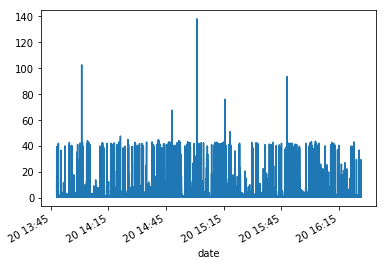

In [13]:
liglab2_date_sorted['time'].plot()

Ca can see that there is a lot of unequal values, so we'll take a closer look at the last 200 entries.

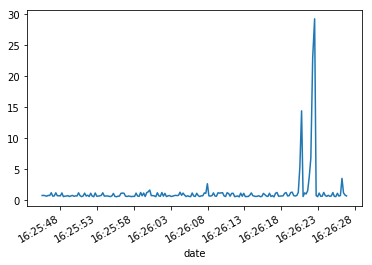

In [14]:
liglab2_date_sorted['time'][-200:].plot()

We can see relitably stable values, with intermittant spikes, some reaching very high. In the first plot, we can see a very high spike, so we can look closer between `15:00` and `15:02`.

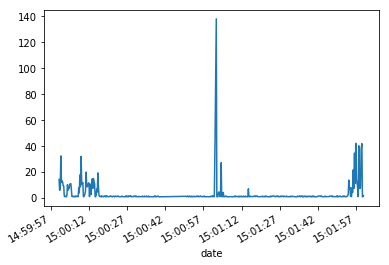

In [15]:
liglab2_date_sorted.between_time('15:00', '15:02')['time'].plot()

Once again, we can see a relitable level tendancy with multiple variations at the extremities, and one very large spike in the centre.

### Analysis of size and communication time

The previous analysis indicated that there is a significant irregularity of transmition time in the log. Now we will examine the time but this time as a function of the packet size.

In [16]:
liglab2_size_sorted = liglab2_data.set_index('size').sort_index()
liglab2_size_sorted

timestamp                 url           ip  icmp_seq  ttl    time  \
size                                                                         
24    1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.565   
24    1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.560   
24    1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.605   
24    1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.580   
24    1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.550   
24    1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.625   
24    1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.580   
24    1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.550   
24    1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.725   
24    1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.575   
24    1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.560   
24    1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.705   
24    1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   9.250   
24    1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.595   
24    1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.555   
24    1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.580   
24    1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.565   
24    1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.590   
24    1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.565   
24    1.421770e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.560   
24    1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6  10.600   
25    1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.570   
25    1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.645   
25    1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.570   
25    1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.580   
25    1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.520   
25    1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.625   
25    1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.585   
25    1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.535   
25    1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   8.850   
...            ...                 ...          ...       ...  ...     ...   
2006  1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.170   
2006  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6  39.000   
2006  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.190   
2006  1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.175   
2006  1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.275   
2006  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6  26.400   
2006  1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.150   
2006  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.170   
2006  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.195   
2006  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.150   
2007  1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.165   
2007  1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.260   
2007  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.095   
2007  1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.210   
2007  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.275   
2007  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.235   
2007  1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.155   
2007  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.205   
2007  1.421766e+09  lig-publig.

Now we can visualise the new data.

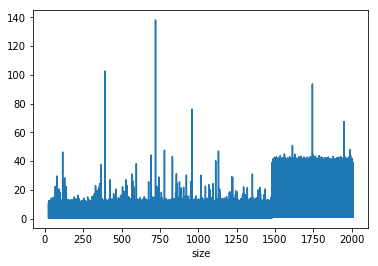

In [17]:
liglab2_size_sorted['time'].plot()

We can immediatly see that just short of *1500*, there is a significant increase in transmission time. We will look closer at this interval, between *1450* and *1500*

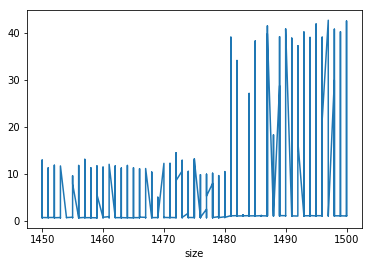

In [18]:
liglab2_size_sorted[(liglab2_size_sorted.index>=1450) & (liglab2_size_sorted.index<=1500)]['time'].plot()

We can clearly see that the increase happens at around *1481*. We can then split the dataset into 2 classes to differenciate the differet mean data values.

In [19]:
liglab2_data_class_a = liglab2_size_sorted[(liglab2_size_sorted.index<1481)]
liglab2_data_class_a

timestamp                 url           ip  icmp_seq  ttl    time  \
size                                                                         
24    1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.565   
24    1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.560   
24    1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.605   
24    1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.580   
24    1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.550   
24    1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.625   
24    1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.580   
24    1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.550   
24    1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.725   
24    1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.575   
24    1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.560   
24    1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.705   
24    1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   9.250   
24    1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.595   
24    1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.555   
24    1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.580   
24    1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.565   
24    1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.590   
24    1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.565   
24    1.421770e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.560   
24    1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6  10.600   
25    1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.570   
25    1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.645   
25    1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.570   
25    1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.580   
25    1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.520   
25    1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.625   
25    1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.585   
25    1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.535   
25    1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   8.850   
...            ...                 ...          ...       ...  ...     ...   
1479  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.780   
1479  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.840   
1479  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.725   
1479  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.715   
1479  1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.690   
1479  1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.725   
1479  1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   9.650   
1479  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.805   
1479  1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.750   
1479  1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.865   
1479  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.840   
1479  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.730   
1480  1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.900   
1480  1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   8.000   
1480  1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.740   
1480  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.750   
1480  1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.735   
1480  1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   0.750   
1480  1.421764e+09  lig-publig.

In [20]:
liglab2_data_class_b = liglab2_size_sorted[(liglab2_size_sorted.index>=1481)]
liglab2_data_class_b

timestamp                 url           ip  icmp_seq  ttl    time  \
size                                                                         
1481  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.140   
1481  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.075   
1481  1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.125   
1481  1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.115   
1481  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6  19.050   
1481  1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.305   
1481  1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.145   
1481  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.180   
1481  1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.155   
1481  1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.135   
1481  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.135   
1481  1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.140   
1481  1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.215   
1481  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6  39.050   
1481  1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.120   
1481  1.421771e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.085   
1481  1.421764e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.170   
1481  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.150   
1481  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.085   
1481  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.155   
1481  1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.105   
1482  1.421770e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.145   
1482  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.075   
1482  1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.150   
1482  1.421770e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.065   
1482  1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.130   
1482  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6  34.100   
1482  1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.180   
1482  1.421770e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.160   
1482  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.200   
...            ...                 ...          ...       ...  ...     ...   
2006  1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.170   
2006  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6  39.000   
2006  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.190   
2006  1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.175   
2006  1.421768e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.275   
2006  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6  26.400   
2006  1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.150   
2006  1.421766e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.170   
2006  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.195   
2006  1.421763e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.150   
2007  1.421769e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.165   
2007  1.421767e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.260   
2007  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.095   
2007  1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.210   
2007  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.275   
2007  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.235   
2007  1.421762e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.155   
2007  1.421765e+09  lig-publig.imag.fr  129.88.11.7         1    6   1.205   
2007  1.421766e+09  lig-publig.

### Estimate network time function

In networking, the following function can specify transmission duration: `T(X) = L + S/C`

| Variable name  | Description                                         |
|----------------|-----------------------------------------------------|
| `T`            | Transmission time, in **seconds**                   |
| `S`            | Size of packet transmitted, in **bytes**            |
| `L`            | Network latency, in **seconds**                     |
| `C`            | Network capacity, in **bytes per second**           |

We can vulgaraly associate the duration function to a linear function corresponding to `Y(X) = ax + b`. Using linear regression, we can estimate both the coeficient `a` and the constant `b`.

#### Class A

We first start by analysing class **A**.

Firstly, we convert and reshape the data corresponding to `X` in the formula, in this case the index corresponding to the packet `size`.

In [21]:
liglab2_class_a_X = liglab2_data_class_a.index.values.reshape(-1, 1)
liglab2_class_a_X

array([[  24],
       [  24],
       [  24],
       ...,
       [1480],
       [1480],
       [1480]])

Secondly, we convert and reshape the `time` to correspond to the `Y` value.

In [22]:
liglab2_class_a_Y = liglab2_data_class_a['time'].values.reshape(-1, 1)
liglab2_class_a_Y

array([[0.565],
       [0.56 ],
       [0.605],
       ...,
       [2.47 ],
       [3.21 ],
       [0.775]])

We now prepare the regressor and fit it with the training data, before predicting the `Y` values corresponding to the linear function.

In [23]:
lin_reg = LinearRegression()
lin_reg.fit(liglab2_class_a_X, liglab2_class_a_Y)
liglab2_class_a_Y_pred = lin_reg.predict(liglab2_class_a_X)
liglab2_class_a_Y_pred

array([[1.64175289],
       [1.64175289],
       [1.64175289],
       ...,
       [1.8793109 ],
       [1.8793109 ],
       [1.8793109 ]])

We not create a plot, superposing the `Y prediction` values ontop of the real `Y` values.

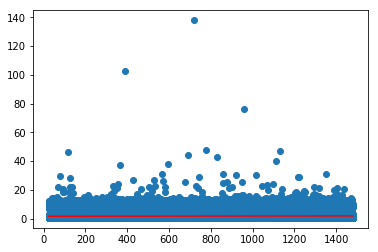

In [24]:
plt.scatter(liglab2_class_a_X, liglab2_class_a_Y)
plt.plot(liglab2_class_a_X, liglab2_class_a_Y_pred, color='red')
plt.show()

We can see the predicted values in red corresponding to the output of the function `Y(X) = ax + b`. Now however, we want to determine both `a` and `b`.

If we associate this function with the function corresponding to network transmission time `T(S) = L + S/C`, we can extrapolate the `b = L` and `a = 1 / C`.

Firstly, we will determine the value of `C`, the network capacity.

In [25]:
liglab2_class_a_C = 1 / lin_reg.coef_[0][0]
liglab2_class_a_C

6129.029233797274

Since the transmission time is specified in *miliseconds* in the logs, the value of `C` here corresponds to `bytes / milisecond`. We will convert this into `bytes / second`.

In [26]:
liglab2_class_a_C_s = liglab2_class_a_C * 1000
liglab2_class_a_C_s

6129029.2337972745

We can convert it into a more human readable version

In [27]:
print("C = " + str(liglab2_class_a_C / 1024 / 1024 ) + " MB/s")

C = 0.005845097764775538 MB/s


Now we will determine the value of `L`, the network latency.

In [28]:
liglab2_class_a_L = lin_reg.intercept_[0]
liglab2_class_a_L

1.6378370996969718

like before, the latency here is specified in *miliseconds*, however the value of `L` is specified in `seconds`.


In [29]:
liglab2_class_a_L_s = liglab2_class_a_L / 1000
liglab2_class_a_L_s

0.0016378370996969719

We can therefore determine that for class **A**, the values for `C` and `L` are as follows:

In [30]:
print("C = " + str(liglab2_class_a_C_s) + " B/s")
print("L = " + str(liglab2_class_a_L_s) + " s")

C = 6129029.2337972745 B/s
L = 0.0016378370996969719 s


A more human friendly representation is the following:

In [31]:
print("C = " + str(liglab2_class_a_C_s / 1024 / 1024 ) + " MB/s")
print("L = " + str(liglab2_class_a_L) + " ms")

C = 5.845097764775538 MB/s
L = 1.6378370996969718 ms


#### Class B

Now we perform the same analysis, but with class **B**.

As previously, we convert and reshape the packet `size` and `time` data for `X` and `Y` values.

In [32]:
liglab2_class_b_X = liglab2_data_class_b.index.values.reshape(-1, 1)
liglab2_class_b_Y = liglab2_data_class_b['time'].values.reshape(-1, 1)

We once again fit the regressor, and predict the Y values. We finaly show a plot with the results.

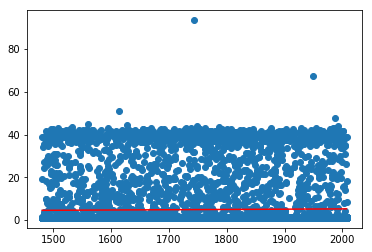

In [39]:
lin_reg.fit(liglab2_class_b_X, liglab2_class_b_Y)
liglab2_class_b_Y_pred = lin_reg.predict(liglab2_class_b_X)

plt.scatter(liglab2_class_b_X, liglab2_class_b_Y)
plt.plot(liglab2_class_b_X, liglab2_class_b_Y_pred, color='red')
plt.show()

We can now determine the `C` and `L` values for class **B**

In [46]:
liglab2_class_b_C = 1 / lin_reg.coef_[0][0]
liglab2_class_b_C_s = liglab2_class_a_C * 1000

liglab2_class_b_L = lin_reg.intercept_[0]
liglab2_class_b_L_s = liglab2_class_a_L / 1000

print("C = " + str(liglab2_class_b_C_s) + " B/s")
print("L = " + str(liglab2_class_b_L_s) + " s")

C = 6129029.2337972745 B/s
L = 0.0016378370996969719 s


Once again, we can print a more human compatable representation

In [47]:
print("C = " + str(liglab2_class_b_C_s / 1024 / 1024 ) + " MB/s")
print("L = " + str(liglab2_class_b_L) + " ms")

C = 5.845097764775538 MB/s
L = 0.6483398536963634 ms


### Noise reduction

#### Class A

Due to the large variablilty in the data, it is difficult to reach a correct value. To do so, we will parse the data and keep only the smalest transmission `time` per packet `size`, then convert it into a pandas dataframe.

In [144]:
def extract_unique(dataframe):
    unique = dataframe.index.unique()
    list = []
    for size in unique:
        values = {}
        time = liglab2_size_sorted.loc[dataframe.index == size, 'time'].min() 
        values['size'] = size
        values['time'] = time
        list.append(values)
    return list
        
#liglab2_min_data_class_a = extract_unique(liglab2_data_class_a)
liglab2_min_data_class_a = extract_unique(liglab2_size_sorted)

liglab2_min_class_a = pd.DataFrame(liglab2_min_data_class_a)#.set_index('size').sort_index()
liglab2_min_class_a

size   time
0       24  0.550
1       25  0.515
2       26  0.540
3       27  0.530
4       28  0.540
5       29  0.515
6       30  0.540
7       31  0.535
8       32  0.505
9       33  0.530
10      34  0.510
11      35  0.515
12      36  0.525
13      37  0.525
14      38  0.530
15      39  0.515
16      40  0.520
17      41  0.530
18      42  0.535
19      43  0.520
20      44  0.520
21      45  0.505
22      46  0.530
23      47  0.535
24      48  0.505
25      49  0.500
26      50  0.515
27      51  0.525
28      52  0.515
29      53  0.520
...    ...    ...
1954  1978  1.095
1955  1979  1.130
1956  1980  1.090
1957  1981  1.115
1958  1982  1.115
1959  1983  1.095
1960  1984  1.145
1961  1985  1.125
1962  1986  1.115
1963  1987  1.105
1964  1988  1.120
1965  1989  1.115
1966  1990  1.090
1967  1991  1.120
1968  1992  1.115
1969  1993  1.120
1970  1994  1.105
1971  1995  1.120
1972  1996  1.140
1973  1997  1.105
1974  1998  1.140
1975  1999  1.115
1976  2000  1.095
1977  2001  1.125
1978  2002  1.130
1979  2003  1.110
1980  2004  1.100
1981  2005  1.125
1982  2006  1.130
1983  2007  1.095

[1984 rows x 2 columns]

We reapply the logistic regression as previously: convert and reshape the packet size and time data for `X` and `Y` values, fit the regressor, predict the `Y` value and show a plot.

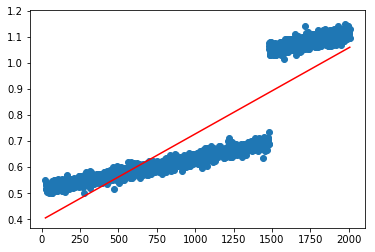

In [145]:
#liglab2_min_class_a_X = liglab2_min_class_a.index.values.reshape(-1, 1)
liglab2_min_class_a_X = liglab2_min_class_a['size'].values.reshape(-1, 1)
liglab2_min_class_a_Y = liglab2_min_class_a['time'].values.reshape(-1, 1)

lin_reg.fit(liglab2_min_class_a_X, liglab2_min_class_a_Y)
liglab2_min_class_a_Y_pred = lin_reg.predict(liglab2_min_class_a_X)

plt.scatter(liglab2_min_class_a_X, liglab2_min_class_a_Y)
plt.plot(liglab2_min_class_a_X, liglab2_min_class_a_Y_pred, color='red')
plt.show()

We can now determine the `C` and `L` values for the minimum version of class **A**.

In [158]:
print(lin_reg.coef_[0][0])
liglab2_min_class_a_C = 1 / lin_reg.coef_[0][0]
liglab2_min_class_a_C_s = liglab2_min_class_a_C * 1000

liglab2_min_class_a_L = lin_reg.intercept_[0]
liglab2_min_class_a_L_s = liglab2_min_class_a_L / 1000

print("C = " + str(liglab2_min_class_a_C_s) + " B/s")
print("L = " + str(liglab2_min_class_a_L_s) + " s")

0.00033044542839782086
C = 3026218.292226174 B/s
L = 0.0003969024255265291 s


And a more human compatable representation

In [147]:
print("C = " + str(liglab2_min_class_a_C_s / 1024 / 1024 ) + " MB/s")
print("L = " + str(liglab2_min_class_a_L) + " ms")

C = 2.8860266611348857 MB/s
L = 0.3969024255265291 ms


##### Quantile Regression

In [165]:
mod = smf.quantreg('time ~ size', liglab2_min_class_a)
res = mod.fit()
print(res.summary())
print(res.params['Intercept'])

                         QuantReg Regression Results                          
Dep. Variable:                   time   Pseudo R-squared:               0.4277
Model:                       QuantReg   Bandwidth:                     0.05182
Method:                 Least Squares   Sparsity:                       0.3243
Date:                Wed, 17 Jun 2020   No. Observations:                 1984
Time:                        23:07:23   Df Residuals:                     1982
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3951      0.007     53.323      0.000       0.381       0.410
size           0.0004   6.36e-06     56.153      0.000       0.000       0.000

The condition number is large, 2.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


In [162]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q) :
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['size']] + res.conf_int().loc['size'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('time ~ size', liglab2_min_class_a).fit()
ols_ci = ols.conf_int().loc['size'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['size'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q         a         b        lb        ub
0  0.05  0.487960  0.000131  0.000129  0.000132
1  0.15  0.493689  0.000134  0.000131  0.000137
2  0.25  0.495102  0.000140  0.000136  0.000143
3  0.35  0.493422  0.000147  0.000143  0.000152
4  0.45  0.476521  0.000185  0.000178  0.000191
5  0.55  0.410267  0.000356  0.000344  0.000367
6  0.65  0.437690  0.000354  0.000343  0.000365
7  0.75  0.466886  0.000349  0.000339  0.000358
8  0.85  0.486530  0.000353  0.000344  0.000361
9  0.95  0.505639  0.000359  0.000352  0.000366
{'a': 0.3969024255265286, 'b': 0.00033044542839782076, 'lb': 0.0003225227391466739, 'ub': 0.00033836811764896763}


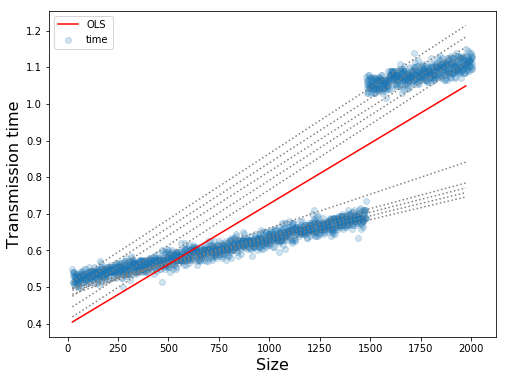

In [164]:
x = np.arange(liglab2_min_class_a['size'].min(), liglab2_min_class_a['size'].max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(liglab2_min_class_a['size'], liglab2_min_class_a['time'], alpha=.2)
#ax.set_xlim((240, 3000))
#ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Size', fontsize=16)
ax.set_ylabel('Transmission time', fontsize=16);